<a href="https://colab.research.google.com/github/faizanahemad/eva/blob/master/assignment-14/DavidNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**List of Changes**

- Apply OLR


In [1]:
import numpy as np
import time, math
import gc
import tensorflow as tf


import matplotlib.pyplot as plt
% matplotlib inline
%config InlineBackend.figure_format='retina'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

print(tf.__version__)

1.13.1


In [2]:
tf.enable_eager_execution()


In [3]:
BATCH_SIZE = 512 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 0.4 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 24 #@param {type:"integer"}

In [28]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
    fan = np.prod(shape[:-1])
    bound = 1 / (math.sqrt(fan))
    return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

def init_pytorch(shape, dtype=tf.float32, partition_info=None):
    fan = np.prod(shape[:-1])
    bound = 0.5 / (math.sqrt(fan))
    return tf.random.truncated_normal(shape, mean=0,stddev=bound)


class ConvBN(tf.keras.Model):
    def __init__(self, c_out):
        super().__init__()
        self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
        self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)

    def call(self, inputs):
        return tf.nn.relu(self.bn(self.conv(inputs)))
    
class BottleNeck(tf.keras.Model):
    def __init__(self, c_out):
        super().__init__()
        self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=1, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
        self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)

    def call(self, inputs):
        return tf.nn.relu(self.bn(self.conv(inputs)))
    
    
class ResBlk(tf.keras.Model):
    def __init__(self, c_out, pool, res = False, pooling=False):
        super().__init__()
        self.conv_bn = ConvBN(c_out)
        self.pool = pool
        self.res = res
        self.pooling = pooling
        self.bottleneck = BottleNeck(c_out)
        if self.res:
            self.res1 = ConvBN(c_out)
            self.res2 = ConvBN(c_out)

    def call(self, inputs):
        if self.pooling:
            h = self.pool(self.conv_bn(inputs))
        else:
            h = self.bottleneck(inputs)
        
        if self.res:
            residual = self.res2(self.res1(h))
            h = h + residual
        return h
    
    
class DavidNet(tf.keras.Model):
    def __init__(self, c=64, weight=0.125):
        super().__init__()
        pool = tf.keras.layers.MaxPooling2D()
        self.init_conv_bn = ConvBN(c)
        self.blk1 = ResBlk(c*2, pool, res = True, pooling = True)
        self.blk2 = ResBlk(c*4, pool, pooling = True)
        self.blk3 = ResBlk(c*8, pool, res = True)
        self.pool = tf.keras.layers.GlobalMaxPool2D()
        self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
        self.weight = weight

    def call(self, x, y):
        h = self.pool(self.blk3(self.blk2(self.blk1(self.init_conv_bn(x)))))
        h = self.linear(h) * self.weight
        ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
        loss = tf.reduce_sum(ce)
        correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
        return loss, correct

In [29]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
len_train, len_test = len(x_train), len(x_test)
y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)

train_mean = np.mean(x_train, axis=(0,1,2))
train_std = np.std(x_train, axis=(0,1,2))

normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here
pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

x_train = normalize(pad4(x_train))
x_test = normalize(x_test)

In [30]:
print(gc.collect())
model = DavidNet()
batches_per_epoch = len_train//BATCH_SIZE + 1

def lr_schedule(t):
    if t<=EPOCHS-2:
        lr = np.interp([t], [0, (EPOCHS+1)//5, EPOCHS-1], [0.0001, LEARNING_RATE, 0.0001])[0]
    else:
        lr = np.interp([t], [ EPOCHS-1, EPOCHS], [0.0001, 0.00001])[0]
  
    return lr


# lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])[0]
lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS], [0.001, LEARNING_RATE, 0.0001])[0]
global_step = tf.train.get_or_create_global_step()
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)


opt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)
data_aug = lambda x, y: (tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3])), y)

704


98 24


<Figure size 576x432 with 0 Axes>

Text(0.5, 1.0, 'Min LR = 0.00100, Max LR = 0.40000, Min Tail LR = 0.00031')

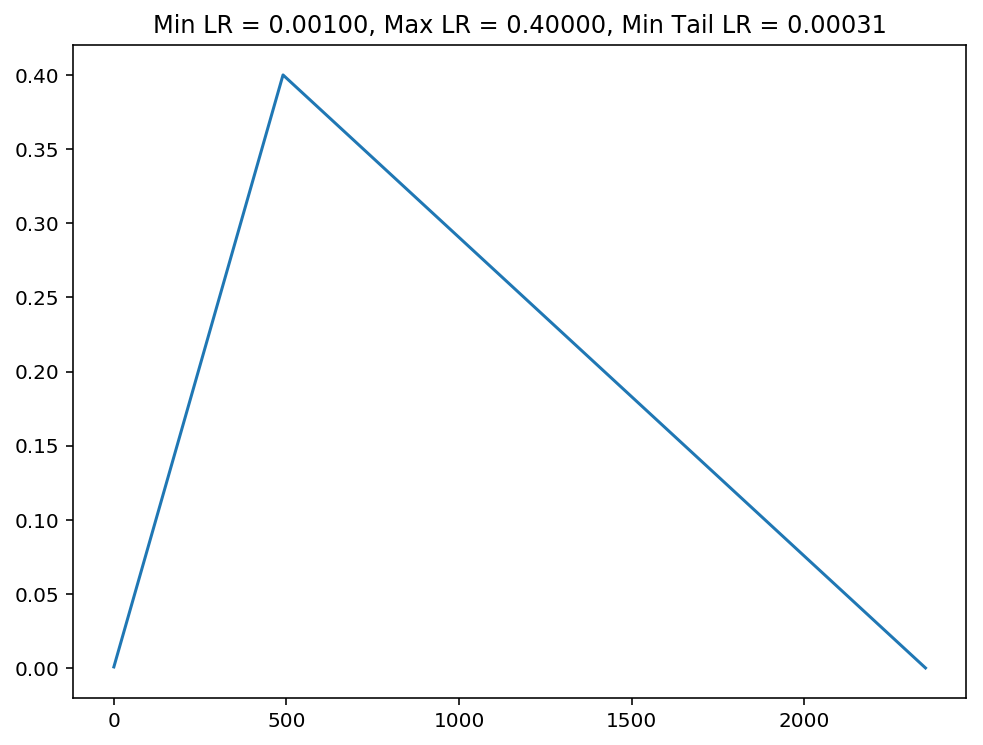

In [31]:
print(batches_per_epoch, EPOCHS)

lrs = []
for i in range(batches_per_epoch*EPOCHS):
    lrs.append(lr_schedule(i/batches_per_epoch))

plt.figure(figsize=(8,6))
plt.plot(lrs)
plt.title("Min LR = %.5f, Max LR = %.5f, Min Tail LR = %.5f"%(np.min(lrs[:len(lrs)//2]),np.max(lrs),np.min(lrs)))
plt.show()


In [32]:
t = time.time()
t_last = time.time()
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

for epoch in range(EPOCHS):
    train_loss = test_loss = train_acc = test_acc = 0.0
    train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(data_aug).shuffle(len_train).batch(BATCH_SIZE).prefetch(1)

    tf.keras.backend.set_learning_phase(1)
    for (x, y) in train_set:
        with tf.GradientTape() as tape:
            loss, correct = model(x, y)

        var = model.trainable_variables
        grads = tape.gradient(loss, var)
        for g, v in zip(grads, var):
            g += v * WEIGHT_DECAY * BATCH_SIZE
        opt.apply_gradients(zip(grads, var), global_step=global_step)

        train_loss += loss.numpy()
        train_acc += correct.numpy()

    tf.keras.backend.set_learning_phase(0)
    for (x, y) in test_set:
        loss, correct = model(x, y)
        test_loss += loss.numpy()
        test_acc += correct.numpy()
    t2 = time.time()
    epoch_time = t2 - t_last
    t_last = t2

    print('lr: %.4f' % (lr_schedule(epoch+1)), '| train loss: %.4f' %(train_loss / len_train), 'train acc: %.3f' % (train_acc / len_train), 'val loss: %.4f' % (test_loss / len_test), 'val acc: %.3f' %(test_acc / len_test),"epoch time: %.2f"%(epoch_time), 'time: %.2f'%(t2 - t))
  
  # 92.79

lr: 0.0808 | train loss: 1.3551 train acc: 0.510 val loss: 0.9766 val acc: 0.652 epoch time: 20.72 time: 20.72
lr: 0.1606 | train loss: 0.7561 train acc: 0.735 val loss: 0.6688 val acc: 0.763 epoch time: 19.44 time: 40.16
lr: 0.2404 | train loss: 0.5576 train acc: 0.808 val loss: 0.6217 val acc: 0.781 epoch time: 19.37 time: 59.53
lr: 0.3202 | train loss: 0.4519 train acc: 0.845 val loss: 0.5099 val acc: 0.828 epoch time: 19.46 time: 78.99
lr: 0.4000 | train loss: 0.3833 train acc: 0.872 val loss: 0.5460 val acc: 0.814 epoch time: 19.46 time: 98.46
lr: 0.3790 | train loss: 0.3380 train acc: 0.886 val loss: 0.5559 val acc: 0.804 epoch time: 19.45 time: 117.91
lr: 0.3579 | train loss: 0.2983 train acc: 0.899 val loss: 0.4395 val acc: 0.850 epoch time: 19.45 time: 137.36
lr: 0.3369 | train loss: 0.2647 train acc: 0.910 val loss: 0.4313 val acc: 0.856 epoch time: 19.48 time: 156.84
lr: 0.3158 | train loss: 0.2371 train acc: 0.920 val loss: 0.3593 val acc: 0.878 epoch time: 19.66 time: 176.

In [ ]:
# Dropout
# OneCycleLR
# Cutout


# Big ideas
# Use Resnet with a highway network like mode with weights for residual, Penalize the weight for residual for its distance from 1.
# Instead of L2 penalization of kernel weights use a Penalization which treats distance from 1/fan-in of weights.

## Normal CNN

In [14]:
class ConvBN(tf.keras.Model):
    def __init__(self, c_out):
        super().__init__()
        self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
        self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)

    def call(self, inputs):
        return tf.nn.relu(self.bn(self.conv(inputs)))
    
class BottleNeck(tf.keras.Model):
    def __init__(self, c_out):
        super().__init__()
        self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=1, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
        self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)

    def call(self, inputs):
        return tf.nn.relu(self.bn(self.conv(inputs)))
    
    
class ResBlk(tf.keras.Model):
    def __init__(self, c_out, pool, res = False):
        super().__init__()
        self.conv_bn = ConvBN(c_out)
        self.pool = pool
        self.res = res
        if self.res:
            self.res1 = ConvBN(c_out)
            self.res2 = ConvBN(c_out)

    def call(self, inputs):
        h = self.pool(self.conv_bn(inputs))
        if self.res:
            h = h + self.res2(self.res1(h))
        return h
    
    
class SimpleNet(tf.keras.Model):
    def __init__(self, c=64, weight=0.00125):
        super().__init__()
        
        pool = tf.keras.layers.MaxPooling2D()
        self.mp = pool
        self.init_conv_bn = ConvBN(c)
        self.conv2 = ConvBN(c*2)
        self.conv3 = ConvBN(c*4)
        # pool
        self.bnl1 = BottleNeck(c)
        self.conv4 = ConvBN(c*2)
        self.conv5 = ConvBN(c*4)
        # pool
        self.bnl2 = BottleNeck(c)
        self.conv6 = ConvBN(c*2)
        self.conv7 = ConvBN(c*4)
        
        self.pool = tf.keras.layers.GlobalMaxPool2D()
        self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
        self.weight = weight

    def call(self, x, y):
        
        x = self.init_conv_bn(x)
        x = self.mp(self.conv3(self.conv2(x)))
        x = self.mp(self.conv5(self.conv4(self.bnl1(x))))
        x = self.conv7(self.conv6(self.bnl2(x)))
        
        h = self.pool(x)
        h = self.linear(h) * self.weight
        ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
        loss = tf.reduce_sum(ce)
        correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
        return loss, correct

In [15]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
len_train, len_test = len(x_train), len(x_test)
y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)

train_mean = np.mean(x_train, axis=(0,1,2))
train_std = np.std(x_train, axis=(0,1,2))

normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here
pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

x_train = normalize(pad4(x_train))
x_test = normalize(x_test)

In [16]:
print(gc.collect())
model = SimpleNet()
batches_per_epoch = len_train//BATCH_SIZE + 1


# lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])[0]
lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS], [0.001, LEARNING_RATE, 0.0001])[0]
global_step = tf.train.get_or_create_global_step()
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)


opt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)
data_aug = lambda x, y: (tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3])), y)

733


In [17]:
t = time.time()
t_last = time.time()
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

for epoch in range(EPOCHS):
    train_loss = test_loss = train_acc = test_acc = 0.0
    train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(data_aug).shuffle(len_train).batch(BATCH_SIZE).prefetch(1)

    tf.keras.backend.set_learning_phase(1)
    for (x, y) in train_set:
        with tf.GradientTape() as tape:
            loss, correct = model(x, y)

        var = model.trainable_variables
        grads = tape.gradient(loss, var)
        for g, v in zip(grads, var):
            g += v * WEIGHT_DECAY * BATCH_SIZE
        opt.apply_gradients(zip(grads, var), global_step=global_step)

        train_loss += loss.numpy()
        train_acc += correct.numpy()

    tf.keras.backend.set_learning_phase(0)
    for (x, y) in test_set:
        loss, correct = model(x, y)
        test_loss += loss.numpy()
        test_acc += correct.numpy()
    t2 = time.time()
    epoch_time = t2 - t_last
    t_last = t2

    print('lr: %.4f' % (lr_schedule(epoch+1)), '| train loss: %.4f' %(train_loss / len_train), 'train acc: %.3f' % (train_acc / len_train), 'val loss: %.4f' % (test_loss / len_test), 'val acc: %.3f' %(test_acc / len_test),"epoch time: %.2f"%(epoch_time), 'time: %.2f'%(t2 - t))
  
  # 92.79

lr: 0.0808 | train loss: 1.9850 train acc: 0.223 val loss: 1.7934 val acc: 0.309 epoch time: 23.35 time: 23.35
lr: 0.1606 | train loss: 1.5714 train acc: 0.408 val loss: 1.5812 val acc: 0.441 epoch time: 21.75 time: 45.10
lr: 0.2404 | train loss: 1.2273 train acc: 0.552 val loss: 1.1748 val acc: 0.589 epoch time: 21.69 time: 66.79
lr: 0.3202 | train loss: 0.9450 train acc: 0.663 val loss: 1.0197 val acc: 0.657 epoch time: 21.79 time: 88.58
lr: 0.4000 | train loss: 0.7679 train acc: 0.731 val loss: 0.7182 val acc: 0.753 epoch time: 21.74 time: 110.32
lr: 0.3790 | train loss: 0.6502 train acc: 0.773 val loss: 0.6836 val acc: 0.771 epoch time: 21.79 time: 132.12
lr: 0.3579 | train loss: 0.5729 train acc: 0.800 val loss: 0.6413 val acc: 0.791 epoch time: 21.72 time: 153.83
lr: 0.3369 | train loss: 0.5211 train acc: 0.819 val loss: 0.5717 val acc: 0.804 epoch time: 21.61 time: 175.44
lr: 0.3158 | train loss: 0.4736 train acc: 0.834 val loss: 0.5140 val acc: 0.820 epoch time: 21.75 time: 197